# Twitter Style Transfer Parsing

In [1]:
import csv
import json
import re
import os
from os import listdir
from os.path import isfile, join
import ipdb
import string
import nltk
import ipdb
from typing import List
from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
import pandas as pd 
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /Users/leviv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Twitter accounts that we have data for

In [2]:
raw_path = "raw"
accounts = []
for f in listdir(raw_path): 
    if isfile(join(raw_path, f)):
        accounts.append(raw_path + "/" + f)

for i, file in enumerate(accounts):
    print(str(i) + " : " + file[4:-5])

0 : AyannaPressley
1 : NatlParkService
2 : dril
3 : DalaiLama
4 : ddlovato
5 : AOC
6 : jimmyfallon
7 : TheEllenShow
8 : Mike_Pence
9 : BarackObama
10 : ladygaga
11 : elonmusk
12 : katyperry
13 : justinbieber
14 : SpeakerPelosi
15 : IlhanMN
16 : senatemajldr
17 : realDonaldTrump
18 : helper
19 : rihanna
20 : JohnCornyn
21 : UTAustin
22 : JoeBiden
23 : NPRHealth
24 : tedcruz
25 : austintexasgov


## Remove links and reply tweets from the corpus

In [3]:
# Ignore all Twitter metadata besides text
def tweet_text_only (filename):
    with open(filename) as f:
      data = json.load(f)

    tweets = data['tweets']
    cleaned_tweets = []
    avg_num_tokens = 0
    avg_tweet_len = 0
        
    for tweet in tweets:
        tweet = parse_tweet(tweet['full_text'])
        if (len(tweet) > 0):
            cleaned_tweets.append(tweet)
            
        avg_num_tokens += len(tweet.split())
        avg_tweet_len += len(tweet)
    
    avg_num_tokens /= len(cleaned_tweets)
    avg_tweet_len /= len(cleaned_tweets)
    
    return (cleaned_tweets, avg_num_tokens, avg_tweet_len)
            

# Parse a single tweet
def parse_tweet (tweet):
    # If the tweet is a reply, don't include it
    if tweet[0] == '@':
        return ''
    
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    
    return tweet.replace("\n", " ")

## Output each of the cleaned tweets as a new file

In [4]:
def get_str_rep(tweets):
    content = ''
    for tweet in tweets:
        content += (tweet + "\n")
        
    return content[:-1]

# Dataframe
df = pd.DataFrame(columns = ['Tweets', 'Account'])
sizes = []
avg_tokens = []
avg_lens = []

for i, file in enumerate(accounts):
    (tweets, avg_num_tokens, avg_tweet_len) = tweet_text_only(file)
    
    sizes.append(len(tweets))
    avg_tokens.append(avg_num_tokens)
    avg_lens.append(avg_tweet_len)
    append = pd.DataFrame({"Tweets": tweets, "Account": str(i)})
        
    df = df.append(append) # Append tweets and labels
    
# Only get the most recent tweets that balance the dataset
min_samples = min(sizes)
final_df = pd.DataFrame(columns = ['Tweets', 'Account'])
i = 0

for size in sizes:
    final_df = final_df.append(df.iloc[i:(i+ min_samples)])
    i += size
    
train, test = train_test_split(final_df, test_size=0.3, random_state=42)
# Output a cleaned version of the data
with open('tweets.train.txt', 'w') as train_file:
    train_file.write(get_str_rep(train["Tweets"]))
with open('tweets.train.labels', 'w') as train_label:
    train_label.write(get_str_rep(train["Account"]))

with open('tweets.test.txt', 'w') as test_file:
    test_file.write(get_str_rep(test["Tweets"]))
with open('tweets.test.labels', 'w') as test_label:
    test_label.write(get_str_rep(test["Account"]))

## Generate plots to describe the data

294911


Text(0.5, 1.0, 'Number of cleaned tweets per twitter account')

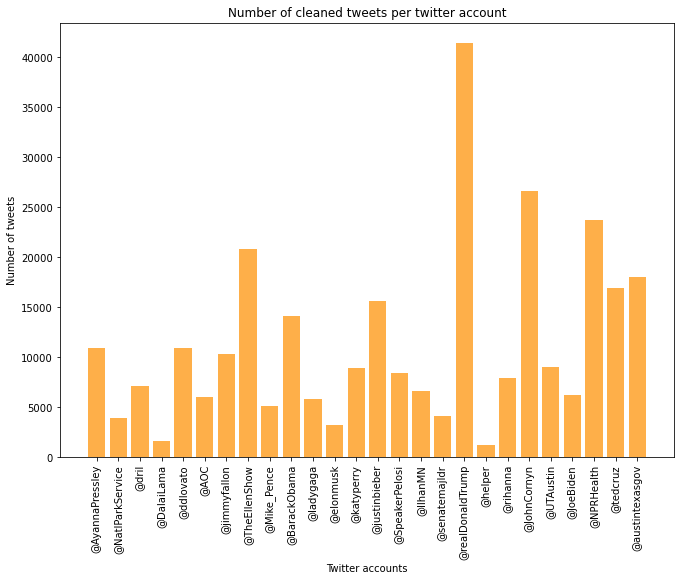

In [5]:
%matplotlib inline
print(sum(sizes))
plt.figure(figsize=(11, 8))
plt.bar(["@" + file[4:-5] for file in accounts], sizes, color='#FEAF49')
plt.xticks(rotation=90)
plt.xlabel("Twitter accounts")
plt.ylabel("Number of tweets")
plt.title("Number of cleaned tweets per twitter account")

Text(0.5, 1.0, 'Average number of tweet tokens per Twitter account')

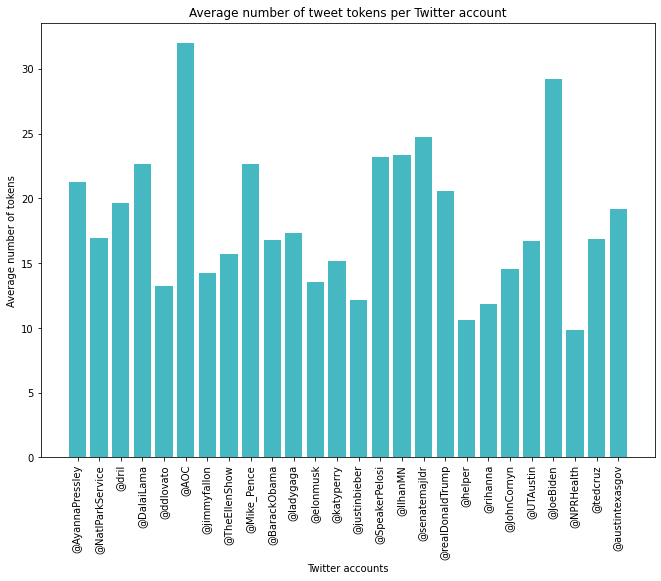

In [6]:
%matplotlib inline
plt.figure(figsize=(11, 8))
plt.bar(["@" + file[4:-5] for file in accounts], avg_tokens, color='#45B8C2')
plt.xticks(rotation=90)
plt.xlabel("Twitter accounts")
plt.ylabel("Average number of tokens")
plt.title("Average number of tweet tokens per Twitter account")

Text(0.5, 1.0, 'Average tweet length per Twitter account')

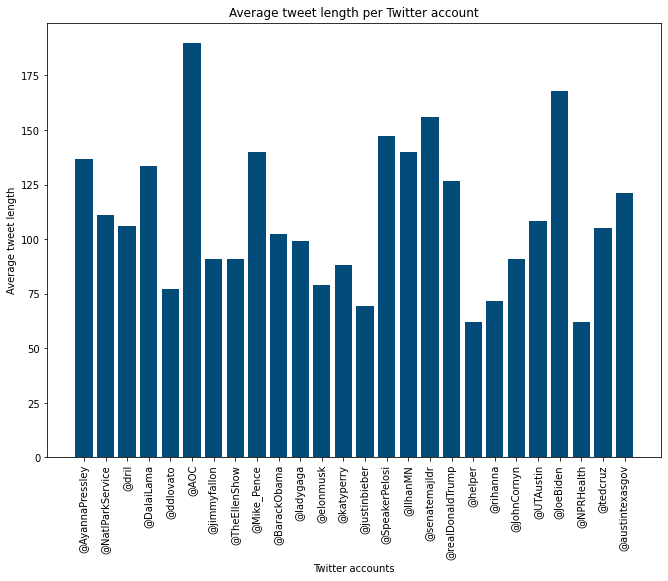

In [7]:
%matplotlib inline
plt.figure(figsize=(11, 8))
plt.bar(["@" + file[4:-5] for file in accounts], avg_lens, color='#034C79')
plt.xticks(rotation=90)
plt.xlabel("Twitter accounts")
plt.ylabel("Average tweet length")
plt.title("Average tweet length per Twitter account")

## Use the cleaned data to create a vocab for the dataset

In [8]:
def clean_tweets(tweets):
    """
    cleans tweets for a single account and return unique tokens.
    """
    uniqueTokens = set()
    
    # clean tweets
    for tweet in tweets:

        tokens = tweet.lower().strip().split()

        # remove punctuation and stopwords
        table = str.maketrans('', '', string.punctuation)
        tokens = [w.translate(table) for w in tokens]

        # filter out non-alphabetic words and stopwords 
        sw = set(stopwords.words('english'))
        tokens = list(filter(lambda x: x.isalpha() and x not in sw, tokens))

        # filter out short tokens
        tokens = list(filter(lambda x: len(x) > 1, tokens))

        uniqueTokens.update(tokens)
        
    return uniqueTokens

In [9]:
# vocabulary for all twitter accounts

def addDocToVocab(account:str, vocab:Counter):
    """
    Reads tweets for given twitter account,
    cleans the tweets, and adds unique tokens
    to the global vocabulary.
    """
    tweets = tweet_text_only(account)[0]
    tokens = clean_tweets(tweets)
    vocab.update(tokens)
    
def processAccounts(accounts:List):
    """
    Adds tweets in each account to the global vocabulary
    
    :arg accounts:list of account names in the data directory
    """
    vocab = Counter()
    
    for account in accounts:
        tweetFile = f'{account}'
        addDocToVocab(tweetFile, vocab)
        
    return vocab

In [10]:
vocab = processAccounts(accounts)

print(len(vocab))

# remove words with a frequency less than 2
corpusVocab = [k for k,c in vocab.items() if c >= 2]

print(len(corpusVocab))

# save the vocab
with open('vocab.txt', 'w') as vocabFile:
    corpusVocab = '\n'.join(corpusVocab)
    vocabFile.write(corpusVocab)

130700
39092
